# Data Analysis of Venues and Housing Reference Prices in Tirana

### By: Ardit Curri

## Table of Contents
<details>
<summary><a href="#item1">1. Introduction</a><br></summary>
&nbsp;&nbsp;<a href="#item2">1.1  Background</a><br>
<details>
<summary>&nbsp;&nbsp;<a href="#item3">1.2 Data sources</a><br></summary>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item4">1.2.1 Administrative units in Municipality of Tirana</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item5">1.2.2 Housing Reference Prices</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item6">1.2.3  Administrative unit area</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item7">1.2.4 Common venues for each administrative unit</a><br>
</details>
</details>
<details>
<summary><a href="#item8">2. Methodology</a> <br></summary>
&nbsp;&nbsp;<a href="#item9">2.1 Analytical approach</a><br>
<details>
<summary>&nbsp;&nbsp;<a href="#item10">2.2 Data exploration</a><br></summary>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item11">2.2.1 Visualise administrative units in Municipality of Tirana</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item12">2.2.2 Average Housing Reference Price ranges</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item13">2.2.3 Common venues for each administrative unit</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#item14">2.2.4 Cluster each administrative unit based on venues</a><br>
</details>
</details>
<details>
<summary><a href="#item15">3. Results</a> <br></summary>
&nbsp;&nbsp;<a href="#item16">3.1 Create results</a><br>
&nbsp;&nbsp;<a href="#item17">3.2 Discussion</a><br>
</details>
<a href="#item18">4. Conclusion</a> <br>
<a href="#item19">5. References</a> <br>


<a id='item1'></a>

## 1. Introduction

<a id='item2'></a>

### 1.1  Background

Tirana is the heart and capital of Albania where over half a million people live. I have decided to use Tirana in my project, as I was born and raised in this city. The city's territory has been inhabited since the Iron Age, but it started as a city in 1614 and since 1920 it has been the capital of Albania and is the most important economic, financial, political and trade centre in Albania.

Tirana, being a growing and crowded city, is becoming a challenge for investors to find the right place to invest for their business. For investors, they would prefer the neighbourhoods with a lower price and to fit the type of business they will open.

The aim of this project is to help investors understand the housing reference prices and categories of venues operating for each neighbourhood. To help them, we will create a map of Tirana and its neighbourhoods to show information on the real estate index and cluster by the venues.

Tirana consists of 13 rural administrative units and city of Tirana, which consists of eleven urban administrative units. For the purpose of this project, we will consider only urban administrative units, as the available data on Foursquare are very few. Note: Administrative units are referred as Neighbourhoods during the course of the project.

<a id='item3'></a>

### 1.2 Data sources

To solve our challenge we will use the below data:
1. Administrative units in Municipality of Tirana - the .json file has all the administrative units and coordinates for Municipality of Tirana. The data have been cleaned and kept only for urban administrative units. Source: https://opendata.tirana.al/sites/default/files/Selia_Nj_Admin_2019.geojson
2. Housing Reference Prices - the information has for each administrative unit and subunit the housing reference price per meter square. Source:https://www.tirana.al/artikull/informacion-mbi-tregun-e-pasurive-te-paluajtshme-ne-qytetin-e-tiranes
3. Common venues for each administrative unit - used Foursquare API to get the most common venues in Tirana, their categories etc.
4. Administrative unit area - the .geojson file has all the administrative units and polygon coordinates for Municipality of Tirana. I cleaned the data and kept only urban administrative units. Source:https://opendata.tirana.al/sites/default/files/Density_NjA.txt

To solve our challenge I will start with administrative units in Municipality of Tirana on the map.
For each neighbourhood, on a radius of 750 meters will collect all the venues (limit to 100). Each neighbourhood will be clustered based on the Foursquare API venue results (will consider the optimal clustering number).
For each neighbourhood, based on reference prices, will be grouped into low, medium and high prices. 
In the end, the map will show the map of Tirana coloured for each neighbourhood area based on the Housing Reference Prices (Choropleth) and each neighbourhood will have a colour based on cluster. On mouse over you will be able to see the name of the unit, cluster on venues and housing reference price group.

<a id='item4'></a>

#### 1.2.1 Administrative units in Municipality of Tirana

Before we start with the main lab content, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


!pip install geopandas
import geopandas as gpd #transform geojson to geopandas
!pip install geojson
import geojson #transform data from panda to geojson
from json import dump

# convert an address into latitude and longitude values
!pip install geopy 
from geopy.geocoders import Nominatim 



# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#
!pip install folium
import folium # map rendering library


%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

print('Packages imported')

Packages imported


Get the data for each Administrative unit in Municipality of Tirana

In [2]:
!wget -q -O 'tirana_data.json' https://opendata.tirana.al/sites/default/files/Selia_Nj_Admin_2019.geojson
print('Data downloaded!')

Data downloaded!


The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.

In [3]:
with open('tirana_data.json') as json_data:
    tirana_data = json.load(json_data)

In [4]:
administrative_unit_data = tirana_data['features']
administrative_unit_data[0]

{'type': 'Feature',
 'properties': {'Id': 12, 'Nj_Admin': 'Nj. Admin DAJT'},
 'geometry': {'type': 'Point',
  'coordinates': [19.885601101761495, 41.352236813735]}}

In [5]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
administrative_units = pd.DataFrame(columns=column_names)

In [6]:
for data in administrative_unit_data:
    administrative_unit  = data['properties']['Nj_Admin']        
    adm_unit_latlon = data['geometry']['coordinates']
    adm_unit_lat = adm_unit_latlon[1]
    adm_unit_lon = adm_unit_latlon[0]
    
    administrative_units = administrative_units.append({'Neighborhood': administrative_unit,
                                          'Latitude': adm_unit_lat,
                                          'Longitude': adm_unit_lon}, ignore_index=True)

In [7]:
administrative_units.head()

,Neighborhood,Latitude,Longitude
0,Nj. Admin DAJT,41.352237,19.885601
1,Nj. Admin KRRABE,41.218266,19.971917
2,Nj. Admin 2,41.325902,19.830347
3,Nj. Admin 1,41.328529,19.833451
4,Nj. Admin 9,41.332104,19.816886


Keep only the administrative units within the urban area of Tirana

In [8]:
keep_list = ['Nj. Admin 1', 'Nj. Admin 2', 'Nj. Admin 3', 'Nj. Admin 4', 'Nj. Admin 5', 'Nj. Admin 6', 'Nj. Admin 7','Nj. Admin 8', 'Nj. Admin 9','Nj. Admin 10', 'Nj. Admin 11']
administrative_units = administrative_units[administrative_units['Neighborhood'].isin(keep_list)].reset_index()
administrative_units.head(12)

,index,Neighborhood,Latitude,Longitude
0,2,Nj. Admin 2,41.325902,19.830347
1,3,Nj. Admin 1,41.328529,19.833451
2,4,Nj. Admin 9,41.332104,19.816886
3,5,Nj. Admin 8,41.335277,19.824183
4,6,Nj. Admin 3,41.338969,19.829606
5,7,Nj. Admin 4,41.339041,19.829566
6,8,Nj. Admin 5,41.319825,19.815625
7,9,Nj. Admin 10,41.329220,19.809519
8,11,Nj. Admin 11,41.339570,19.795195
9,14,Nj. Admin 6,41.314590,19.766441


<a id='item5'></a>

#### 1.2.2 Housing Reference Prices

Housing price reference published by Tirana Municipality (ref: https://www.tirana.al/artikull/informacion-mbi-tregun-e-pasurive-te-paluajtshme-ne-qytetin-e-tiranes)
Note: Considered in this analysis only 11 urban administrative units of Tirana City 

In [9]:
price_data = {'Neighborhood':  ['Nj. Admin 1', 'Nj. Admin 1', 'Nj. Admin 2', 'Nj. Admin 2', 'Nj. Admin 2', 'Nj. Admin 2', 'Nj. Admin 2', 'Nj. Admin 3', 'Nj. Admin 3', 'Nj. Admin 4', 'Nj. Admin 4', 'Nj. Admin 5', 'Nj. Admin 5', 'Nj. Admin 5', 'Nj. Admin 5', 'Nj. Admin 6', 'Nj. Admin 7', 'Nj. Admin 7', 'Nj. Admin 7', 'Nj. Admin 7', 'Nj. Admin 8', 'Nj. Admin 8', 'Nj. Admin 8', 'Nj. Admin 9', 'Nj. Admin 9', 'Nj. Admin 9', 'Nj. Admin 10', 'Nj. Admin 10', 'Nj. Admin 10', 'Nj. Admin 11', 'Nj. Admin 11', 'Nj. Admin 11'],
        'Administative_subunit': ['1/1', '1/2', '2/1', '2/2', '2/3', '2/4', '2/5', '3/1', '3/2', '4/1', '4/2', '5/1', '5/2', '5/3', '5/4', '6', '7/1', '7/2', '7/3', '7/4', '8/1', '8/2', '8/3', '9/1', '9/2', '9/3', '10/1', '10/2', '10/3', '11/1', '11/2', '11/3'],
        'RP_squaremeter': [97700, 78000, 187000, 134500, 95000, 110000, 80000, 77000, 60000, 70000, 60000, 190000, 132000, 107000, 82000, 65000, 120000, 100000, 85000, 65000, 110000, 100000, 72000, 130000, 100000, 77000, 145000, 139500, 102000, 87000, 75000, 70000],
        }

tirana_price_data = pd.DataFrame (price_data, columns = ['Neighborhood','Administative_subunit','RP_squaremeter'])

Examine the dataframe

In [10]:
tirana_price_data.head()

,Neighborhood,Administative_subunit,RP_squaremeter
0,Nj. Admin 1,1/1,97700
1,Nj. Admin 1,1/2,78000
2,Nj. Admin 2,2/1,187000
3,Nj. Admin 2,2/2,134500
4,Nj. Admin 2,2/3,95000


As we may notice, each Administrative_unit may have several subunits, we will consider average price for each one of them

In [11]:
tirana_reference_prices = tirana_price_data.groupby(['Neighborhood'])[['RP_squaremeter']].mean().reset_index()
tirana_reference_prices['nr_njesie'] = tirana_reference_prices['Neighborhood'].str.replace('Nj. Admin ','').str.replace(' ','')
tirana_reference_prices.head()

,Neighborhood,RP_squaremeter,nr_njesie
0,Nj. Admin 1,87850.000000,1
1,Nj. Admin 10,128833.333333,10
2,Nj. Admin 11,77333.333333,11
3,Nj. Admin 2,121300.000000,2
4,Nj. Admin 3,68500.000000,3


<a id='item6'></a>

#### 1.2.3  Administrative unit area

For each neighborhood we will get the polygon coordinates so we can colour based on housing reference price.

In [12]:
# download tirana administrative units geojson file
!wget --quiet https://opendata.tirana.al/sites/default/files/Density_NjA.txt
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [13]:
with open('Density_NjA.txt') as json_file:     # name of the text file
    data = json.load(json_file)

with open('tirana_geo.geojson', 'w') as f:   # name of the output geojson file
   dump(data, f)

tirana_geo = gpd.read_file("tirana_geo.geojson")
tirana_geo.head()

,id,nr,nr_njesie,njesia_adm,njesia_a_1,Dendesia_2016_Banore_per_Km2,%_e_ndryshimit_vjetor_2017-2016,Dendesia_2017_Banore_per_Km2,geometry
0,1,11,11,NJA 11,Nja.11,"12,711",-1.677598767,12498,"MULTIPOLYGON (((19.76867 41.36668, 19.76928 41..."
1,2,10,10,NJA 10,Nja.10,"37,635",-4.021540267,36122,"MULTIPOLYGON (((19.80625 41.33397, 19.80648 41..."
2,3,09,9,NJA 9,Nja.9,"21,657",1.220350074,21921,"MULTIPOLYGON (((19.81108 41.35121, 19.81108 41..."
3,18,PEZE,17,NJA PEZE,Nja. Peze,54,0.394375857,54,"MULTIPOLYGON (((19.71910 41.29554, 19.71983 41..."
4,19,VAQARR,14,NJA VAQARR,Nja. Vaqarr,214,4.334334334,223,"MULTIPOLYGON (((19.78329 41.31092, 19.78349 41..."


Keep only the administrative units that are part of urban area of Tirana. For this reason we will 1. transform the file to geopanda 2. clean from unnecessary data 3. transform to geojson to use.

In [14]:
#create geopandas file with polygon data
tirana_gpd = gpd.read_file("tirana_geo.geojson")
tirana_gpd.head(30)

,id,nr,nr_njesie,njesia_adm,njesia_a_1,Dendesia_2016_Banore_per_Km2,%_e_ndryshimit_vjetor_2017-2016,Dendesia_2017_Banore_per_Km2,geometry
0,1,11,11,NJA 11,Nja.11,"12,711",-1.677598767,12498,"MULTIPOLYGON (((19.76867 41.36668, 19.76928 41..."
1,2,10,10,NJA 10,Nja.10,"37,635",-4.021540267,36122,"MULTIPOLYGON (((19.80625 41.33397, 19.80648 41..."
2,3,09,9,NJA 9,Nja.9,"21,657",1.220350074,21921,"MULTIPOLYGON (((19.81108 41.35121, 19.81108 41..."
3,18,PEZE,17,NJA PEZE,Nja. Peze,54,0.394375857,54,"MULTIPOLYGON (((19.71910 41.29554, 19.71983 41..."
4,19,VAQARR,14,NJA VAQARR,Nja. Vaqarr,214,4.334334334,223,"MULTIPOLYGON (((19.78329 41.31092, 19.78349 41..."
5,20,SHENGJERGJ,22,NJA SHENGJERGJ,Nja. Shengjergj,13,-5.19005848,13,"MULTIPOLYGON (((20.07720 41.41086, 20.07808 41..."
6,21,ZALL BASTAR,23,NJA ZALL BASTAR,Nja. Zall Bastar,36,-4.474673349,35,"MULTIPOLYGON (((19.92205 41.51448, 19.92275 41..."
7,22,ZALL HERR,24,NJA ZALL HERR,Nja. Zall Herr,201,2.115138593,205,"MULTIPOLYGON (((19.84355 41.44698, 19.84371 41..."
8,4,08,8,NJA 8,Nja.8,"21,461",-0.890101213,21270,"MULTIPOLYGON (((19.81292 41.35225, 19.81396 41..."
9,5,07,7,NJA 7,Nja.7,"23,560",0.734558987,23733,"MULTIPOLYGON (((19.77859 41.34204, 19.78220 41..."


In [15]:
#keep only the administrative units that are part of urban area
tirana_gpd['nr_njesie_int'] = tirana_gpd['nr_njesie'].astype(int)
tirana_gpd = tirana_gpd[tirana_gpd['nr_njesie_int'] <= 11]  
tirana_gpd.head()

,id,nr,nr_njesie,njesia_adm,njesia_a_1,Dendesia_2016_Banore_per_Km2,%_e_ndryshimit_vjetor_2017-2016,Dendesia_2017_Banore_per_Km2,geometry,nr_njesie_int
0,1,11,11,NJA 11,Nja.11,"12,711",-1.677598767,12498,"MULTIPOLYGON (((19.76867 41.36668, 19.76928 41...",11
1,2,10,10,NJA 10,Nja.10,"37,635",-4.021540267,36122,"MULTIPOLYGON (((19.80625 41.33397, 19.80648 41...",10
2,3,09,9,NJA 9,Nja.9,"21,657",1.220350074,21921,"MULTIPOLYGON (((19.81108 41.35121, 19.81108 41...",9
8,4,08,8,NJA 8,Nja.8,"21,461",-0.890101213,21270,"MULTIPOLYGON (((19.81292 41.35225, 19.81396 41...",8
9,5,07,7,NJA 7,Nja.7,"23,560",0.734558987,23733,"MULTIPOLYGON (((19.77859 41.34204, 19.78220 41...",7


In [16]:
tirana_gpd.drop(['Dendesia_2016_Banore_per_Km2', '%_e_ndryshimit_vjetor_2017-2016', 'Dendesia_2017_Banore_per_Km2', 'nr_njesie_int'], axis=1, inplace=True)
tirana_gpd.to_file("tirana_gpd.geojson", driver='GeoJSON')
tirana_geo_clean = 'tirana_gpd.geojson'

<a id='item7'></a>

#### 1.2.4 Common venues for each administrative unit

This part will be explained in more detail in Methodology section.

<a id='item8'></a>

## 2. Methodology

<a id='item9'></a>

### 2.1 Analytical approach

The data are available in the Municipality of Tirana webpage and will explore the data and visualize using Folium. <br>
To understand what the typical venues are for each unit we will use Foursquare data and gather all the venues in a 750 meters radius. Based on the top venue categories we will cluster the administrative units.

<a id='item10'></a>

### 2.2 Data exploration

We will explore the data discussed during section 1.2 Data Sources

<a id='item11'></a>

#### 2.2.1 Visualise administrative units in Municipality of Tirana

Use geopy library to get the latitude and longitute values of Tirana.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>tr_explorer</em>, as shown below.

In [17]:
address = 'Tirana, AL'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tirana are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tirana are 41.3305141, 19.825562857582966.


Create a map of Tirana with administrative units superimposed on top.

In [18]:
# create map of Tirana using latitude and longitude values
map_tirana = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, Neighborhood in zip(administrative_units['Latitude'], administrative_units['Longitude'], administrative_units['Neighborhood']):
    label = '{}'.format(Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tirana)  
    
map_tirana

<a id='item12'></a>

#### 2.2.2 Average Housing Reference Price ranges

To understand the distribution of prices a histogram can help:

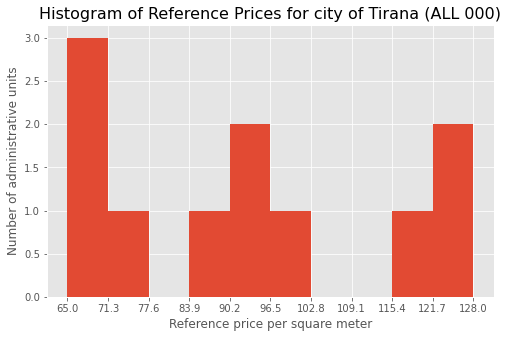

In [19]:
tirana_reference_prices['RP_squaremeter_thousands'] = tirana_reference_prices['RP_squaremeter']/1000
tirana_reference_prices['RP_squaremeter_thousands'] = tirana_reference_prices['RP_squaremeter_thousands'].astype(int)
count, bin_edges = np.histogram(tirana_reference_prices['RP_squaremeter_thousands'])

tirana_reference_prices['RP_squaremeter_thousands'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Reference Prices for city of Tirana (ALL ''000)', fontsize=16)
plt.ylabel('Number of administrative units')
plt.xlabel('Reference price per square meter')

plt.show()

We can see that there are three ranges for prices. Let's create buckets to use in later visualisations.

In [20]:
def price_bucket(row) :
    if row['RP_squaremeter'] <= 77600 :
        return 'Low HRP Level'
    if row['RP_squaremeter'] <= 110000 :
        return 'Medium HRP Level'
    if row['RP_squaremeter'] > 110000 :
        return 'High HRP Level'
    return 'Other'

#create the bucket
tirana_reference_prices['RP_squaremeter'] = tirana_reference_prices.apply (lambda row: price_bucket(row), axis=1)

<a id='item13'></a>

#### 2.2.3 Common venues for each administrative unit

Foursquare API will be utilized to receive for each administrative unit a limit of 100 venue and radius of 750 meters.

Define Frousquare Credentials and Version.

In [1]:
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '###' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Create a function to process all administrative units.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
tirana_venues = getNearbyVenues(names=administrative_units['Neighborhood'],
                                   latitudes=administrative_units['Latitude'],
                                   longitudes=administrative_units['Longitude'],
                                radius= 750
                                  )

Nj. Admin 2
Nj. Admin 1
Nj. Admin 9
Nj. Admin 8
Nj. Admin 3
Nj. Admin 4
Nj. Admin 5
Nj. Admin 10
Nj. Admin 11
Nj. Admin 6
Nj. Admin 7


Let's check the resulting dataframe and the size.

In [24]:
print(tirana_venues.shape)
tirana_venues.head()

(357, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nj. Admin 2,41.325902,19.830347,Fishop,41.322384,19.827218,Seafood Restaurant
1,Nj. Admin 2,41.325902,19.830347,Delano Lounge Restaurant,41.327002,19.824573,Restaurant
2,Nj. Admin 2,41.325902,19.830347,Mulliri Vjeter,41.323451,19.825499,Café
3,Nj. Admin 2,41.325902,19.830347,Edi Fishop,41.322189,19.826643,Fish & Chips Shop
4,Nj. Admin 2,41.325902,19.830347,Gourmet,41.323262,19.823910,Restaurant


Let's see how many venues were returned for each neighborhood.

In [25]:
tirana_venues_count = tirana_venues.groupby(['Neighborhood'])[['Venue Category']].count()
tirana_venues_count.head(10)

,Venue Category
Neighborhood,
Nj. Admin 1,11
Nj. Admin 10,48
Nj. Admin 11,7
Nj. Admin 2,44
Nj. Admin 3,9
Nj. Admin 4,9
Nj. Admin 5,100
Nj. Admin 6,4
Nj. Admin 7,21


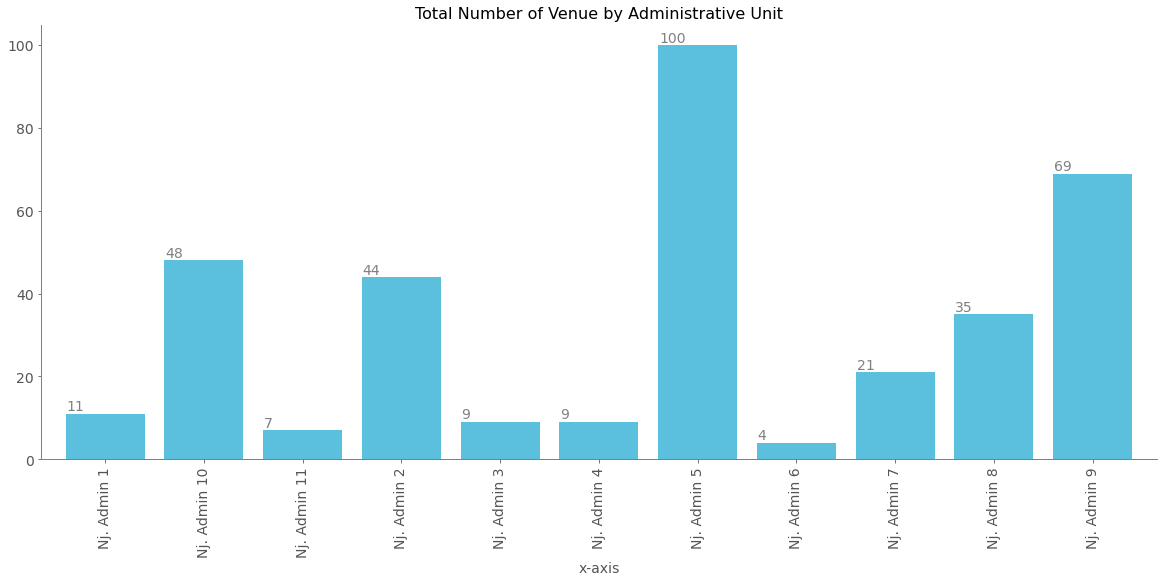

In [26]:
ax = tirana_venues_count.plot(kind='bar',
         figsize=(20, 8),
         width=0.8,
         fontsize=14,
         color=['#5bc0de']
        )

plt. xlabel('x-axis', fontsize=14)
plt.title('Total Number of Venue by Administrative Unit', fontsize=16)
plt.legend() .set_visible(False)

ax.set_facecolor("white")
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['left'].set_color('gray')


for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.01, i.get_height()+0.8, \
            str(round((i.get_height()), 2)), fontsize=14, color='grey')

plt.show()

Let's check how many unique categories are returned from venues.

In [27]:
print('There are {} uniques categories.'.format(len(tirana_venues['Venue Category'].unique())))

There are 64 uniques categories.


Now let's create the new dataframe and display the top 10 venues for each neighborhood.

Analyze each neighborhood (administrative unit).

In [28]:
# one hot encoding
tirana_onehot = pd.get_dummies(tirana_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tirana_onehot['Neighborhood'] = tirana_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tirana_onehot.columns[-1]] + list(tirana_onehot.columns[:-1])
tirana_onehot = tirana_onehot[fixed_columns]

tirana_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,BBQ Joint,Bakery,Bar,Bed & Breakfast,Bistro,Bookstore,Border Crossing,...,Seafood Restaurant,Shopping Mall,Snack Place,Souvlaki Shop,Steakhouse,Tea Room,Theater,Turkish Restaurant,Whisky Bar,Wine Bar
0,Nj. Admin 2,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Nj. Admin 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nj. Admin 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nj. Admin 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nj. Admin 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the new dataframe size.

In [29]:
tirana_onehot.shape

(357, 65)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. Examine the new size.

In [30]:
tirana_grouped = tirana_onehot.groupby('Neighborhood').mean().reset_index()
print(tirana_grouped.shape)
tirana_grouped

(11, 65)


,Neighborhood,American Restaurant,Art Gallery,BBQ Joint,Bakery,Bar,Bed & Breakfast,Bistro,Bookstore,Border Crossing,...,Seafood Restaurant,Shopping Mall,Snack Place,Souvlaki Shop,Steakhouse,Tea Room,Theater,Turkish Restaurant,Whisky Bar,Wine Bar
0,Nj. Admin 1,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00
1,Nj. Admin 10,0.000000,0.000000,0.000000,0.020833,0.166667,0.000000,0.000000,0.020833,0.000000,...,0.020833,0.020833,0.020833,0.000000,0.020833,0.00,0.00,0.000000,0.000000,0.00
2,Nj. Admin 11,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.142857,0.00
3,Nj. Admin 2,0.022727,0.000000,0.022727,0.000000,0.022727,0.000000,0.022727,0.000000,0.000000,...,0.068182,0.022727,0.000000,0.022727,0.000000,0.00,0.00,0.000000,0.000000,0.00
4,Nj. Admin 3,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.111111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00
5,Nj. Admin 4,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.111111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00
6,Nj. Admin 5,0.000000,0.010000,0.010000,0.000000,0.070000,0.010000,0.020000,0.010000,0.000000,...,0.020000,0.000000,0.000000,0.000000,0.000000,0.01,0.01,0.000000,0.000000,0.01
7,Nj. Admin 6,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00
8,Nj. Admin 7,0.000000,0.000000,0.047619,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.047619,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00
9,Nj. Admin 8,0.028571,0.000000,0.000000,0.000000,0.114286,0.028571,0.000000,0.000000,0.028571,...,0.057143,0.000000,0.000000,0.028571,0.000000,0.00,0.00,0.000000,0.000000,0.00


Let's print each neighborhood along with the top 5 most common venues.

In [31]:
num_top_venues = 6

for hood in tirana_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tirana_grouped[tirana_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Nj. Admin 1----
                      venue  freq
0                     Hotel  0.27
1                    Hostel  0.18
2               Coffee Shop  0.09
3        Seafood Restaurant  0.09
4  Mediterranean Restaurant  0.09
5              Dessert Shop  0.09


----Nj. Admin 10----
                venue  freq
0                Café  0.21
1                 Bar  0.17
2               Hotel  0.15
3         Coffee Shop  0.08
4        Cocktail Bar  0.04
5  Italian Restaurant  0.04


----Nj. Admin 11----
               venue  freq
0                Bar  0.29
1              Hotel  0.14
2         Whisky Bar  0.14
3  Electronics Store  0.14
4                Pub  0.14
5              Diner  0.14


----Nj. Admin 2----
                  venue  freq
0                 Hotel  0.11
1                  Café  0.11
2                   Pub  0.07
3          Cocktail Bar  0.07
4    Seafood Restaurant  0.07
5  Fast Food Restaurant  0.05


----Nj. Admin 3----
         venue  freq
0        Hotel  0.33
1  Pop-Up Shop 

Let's create a new dataframe and display the top 10 venues for each neighborhood.

In [32]:
#function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tirana_grouped['Neighborhood']

for ind in np.arange(tirana_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tirana_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Nj. Admin 1,Hotel,Hostel,Seafood Restaurant,BBQ Joint,Coffee Shop,Dessert Shop,Mediterranean Restaurant,American Restaurant,Shopping Mall,Snack Place
1,Nj. Admin 10,Café,Bar,Hotel,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Pizza Place,Lounge,Market
2,Nj. Admin 11,Bar,Whisky Bar,Hotel,Diner,Electronics Store,Pub,Fast Food Restaurant,Eastern European Restaurant,Farmers Market,French Restaurant
3,Nj. Admin 2,Hotel,Café,Cocktail Bar,Seafood Restaurant,Pub,Restaurant,Fast Food Restaurant,Eastern European Restaurant,Hotel Bar,Hookah Bar
4,Nj. Admin 3,Hotel,Nightclub,Bar,Pop-Up Shop,Hotel Pool,Border Crossing,Bakery,Greek Restaurant,Gift Shop,Creperie


<a id='item14'></a>

#### 2.2.4 Cluster each administrative unit based on venues

To present to investors the type of businesses that operate in each administrative unit we will cluster them into groups based on the top venues we received from Foursquare.
For this reason unsupervised learning K-means algorithm will be used to create the categories for each neighborhood.

We will test to cluster for 3 clusters.

In [34]:
# set number of clusters
kclusters = 3

tirana_grouped_clustering = tirana_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tirana_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:11] 

array([0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0], dtype=int32)

We need to evaluate what is the best K-means cluster number based on the Elbow method.

In [35]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tirana_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

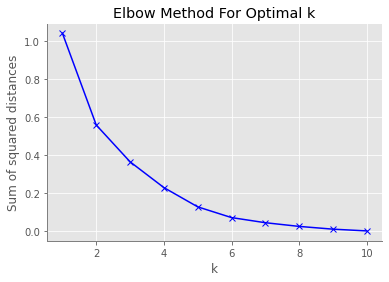

In [36]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')


ax.set_facecolor("white")
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['left'].set_color('gray')

plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The number of optimal clusters seesm to be very high, we will be using k=6.

In [37]:
# set number of clusters for new value
kclusters = 6

tirana_grouped_clustering = tirana_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tirana_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:11] 

array([5, 3, 4, 0, 2, 2, 0, 1, 3, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tirana_merged = administrative_units
# merge tirana_grouped with tirana_data to add latitude/longitude for each neighborhood
tirana_merged = tirana_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on=['Neighborhood'])

tirana_merged.head(11) 

,index,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Nj. Admin 2,41.325902,19.830347,0,Hotel,Café,Cocktail Bar,Seafood Restaurant,Pub,Restaurant,Fast Food Restaurant,Eastern European Restaurant,Hotel Bar,Hookah Bar
1,3,Nj. Admin 1,41.328529,19.833451,5,Hotel,Hostel,Seafood Restaurant,BBQ Joint,Coffee Shop,Dessert Shop,Mediterranean Restaurant,American Restaurant,Shopping Mall,Snack Place
2,4,Nj. Admin 9,41.332104,19.816886,0,Hotel,Café,Bar,Coffee Shop,Pizza Place,Hostel,History Museum,Seafood Restaurant,Italian Restaurant,Cocktail Bar
3,5,Nj. Admin 8,41.335277,19.824183,0,Hotel,Bar,Hostel,Café,Cocktail Bar,Coffee Shop,Seafood Restaurant,Pizza Place,Nightclub,Bed & Breakfast
4,6,Nj. Admin 3,41.338969,19.829606,2,Hotel,Nightclub,Bar,Pop-Up Shop,Hotel Pool,Border Crossing,Bakery,Greek Restaurant,Gift Shop,Creperie
5,7,Nj. Admin 4,41.339041,19.829566,2,Hotel,Nightclub,Bar,Pop-Up Shop,Hotel Pool,Border Crossing,Bakery,Greek Restaurant,Gift Shop,Creperie
6,8,Nj. Admin 5,41.319825,19.815625,0,Cocktail Bar,Café,Italian Restaurant,Bar,Coffee Shop,Hotel,Lounge,Mediterranean Restaurant,Restaurant,Pizza Place
7,9,Nj. Admin 10,41.329220,19.809519,3,Café,Bar,Hotel,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Pizza Place,Lounge,Market
8,11,Nj. Admin 11,41.339570,19.795195,4,Bar,Whisky Bar,Hotel,Diner,Electronics Store,Pub,Fast Food Restaurant,Eastern European Restaurant,Farmers Market,French Restaurant
9,14,Nj. Admin 6,41.314590,19.766441,1,Bar,Bistro,Wine Bar,Fish & Chips Shop,Diner,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Gift Shop


Examine each cluster and label based on top venues.

In [39]:
def venue_label(row) :
    if row['Cluster Labels'] == 0 :
        return 'Hotel; Café; Restaurants; Bar'
    if row['Cluster Labels'] == 1 :
        return 'Bar and Bistro'
    if row['Cluster Labels'] == 2 :
        return 'Multiple venues'
    if row['Cluster Labels'] == 3 :
        return 'Café; Bar; Hotel'
    if row['Cluster Labels'] == 4 :
        return 'Bar and Electronic store'
    if row['Cluster Labels'] == 5 :
        return 'Accommodations and Restaurant'
    return 'Other'

#create the bucket
tirana_merged['Cluster Label Names'] = tirana_merged.apply (lambda row: venue_label(row), axis=1)

Examine new values.

In [40]:
tirana_merged.head(11)

,index,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label Names
0,2,Nj. Admin 2,41.325902,19.830347,0,Hotel,Café,Cocktail Bar,Seafood Restaurant,Pub,Restaurant,Fast Food Restaurant,Eastern European Restaurant,Hotel Bar,Hookah Bar,Hotel; Café; Restaurants; Bar
1,3,Nj. Admin 1,41.328529,19.833451,5,Hotel,Hostel,Seafood Restaurant,BBQ Joint,Coffee Shop,Dessert Shop,Mediterranean Restaurant,American Restaurant,Shopping Mall,Snack Place,Accommodations and Restaurant
2,4,Nj. Admin 9,41.332104,19.816886,0,Hotel,Café,Bar,Coffee Shop,Pizza Place,Hostel,History Museum,Seafood Restaurant,Italian Restaurant,Cocktail Bar,Hotel; Café; Restaurants; Bar
3,5,Nj. Admin 8,41.335277,19.824183,0,Hotel,Bar,Hostel,Café,Cocktail Bar,Coffee Shop,Seafood Restaurant,Pizza Place,Nightclub,Bed & Breakfast,Hotel; Café; Restaurants; Bar
4,6,Nj. Admin 3,41.338969,19.829606,2,Hotel,Nightclub,Bar,Pop-Up Shop,Hotel Pool,Border Crossing,Bakery,Greek Restaurant,Gift Shop,Creperie,Multiple venues
5,7,Nj. Admin 4,41.339041,19.829566,2,Hotel,Nightclub,Bar,Pop-Up Shop,Hotel Pool,Border Crossing,Bakery,Greek Restaurant,Gift Shop,Creperie,Multiple venues
6,8,Nj. Admin 5,41.319825,19.815625,0,Cocktail Bar,Café,Italian Restaurant,Bar,Coffee Shop,Hotel,Lounge,Mediterranean Restaurant,Restaurant,Pizza Place,Hotel; Café; Restaurants; Bar
7,9,Nj. Admin 10,41.329220,19.809519,3,Café,Bar,Hotel,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Pizza Place,Lounge,Market,Café; Bar; Hotel
8,11,Nj. Admin 11,41.339570,19.795195,4,Bar,Whisky Bar,Hotel,Diner,Electronics Store,Pub,Fast Food Restaurant,Eastern European Restaurant,Farmers Market,French Restaurant,Bar and Electronic store
9,14,Nj. Admin 6,41.314590,19.766441,1,Bar,Bistro,Wine Bar,Fish & Chips Shop,Diner,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Gift Shop,Bar and Bistro


<a id='item15'></a>

## 3. Results

<a id='item16'></a>

### 3.1 Create results

In the final visualisation we have a choropleth map for Housing Reference Price for Tirana urban administrative units and added for each neighborhood: 
-   Administrative Unit Name
-   Housing Reference Price range group
-   Cluster name

Add the information on Housing Reference price range to the current dataframe with clusters.

In [41]:
tirana_merged = pd.merge(tirana_merged, tirana_reference_prices, how='left', left_on='Neighborhood', right_on='Neighborhood')

Examine the data.

In [42]:
tirana_merged.head()

,index,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label Names,RP_squaremeter,nr_njesie,RP_squaremeter_thousands
0,2,Nj. Admin 2,41.325902,19.830347,0,Hotel,Café,Cocktail Bar,Seafood Restaurant,Pub,Restaurant,Fast Food Restaurant,Eastern European Restaurant,Hotel Bar,Hookah Bar,Hotel; Café; Restaurants; Bar,High HRP Level,2,121
1,3,Nj. Admin 1,41.328529,19.833451,5,Hotel,Hostel,Seafood Restaurant,BBQ Joint,Coffee Shop,Dessert Shop,Mediterranean Restaurant,American Restaurant,Shopping Mall,Snack Place,Accommodations and Restaurant,Medium HRP Level,1,87
2,4,Nj. Admin 9,41.332104,19.816886,0,Hotel,Café,Bar,Coffee Shop,Pizza Place,Hostel,History Museum,Seafood Restaurant,Italian Restaurant,Cocktail Bar,Hotel; Café; Restaurants; Bar,Medium HRP Level,9,102
3,5,Nj. Admin 8,41.335277,19.824183,0,Hotel,Bar,Hostel,Café,Cocktail Bar,Coffee Shop,Seafood Restaurant,Pizza Place,Nightclub,Bed & Breakfast,Hotel; Café; Restaurants; Bar,Medium HRP Level,8,94
4,6,Nj. Admin 3,41.338969,19.829606,2,Hotel,Nightclub,Bar,Pop-Up Shop,Hotel Pool,Border Crossing,Bakery,Greek Restaurant,Gift Shop,Creperie,Multiple venues,Low HRP Level,3,68


Add the scale for each administrative unit of Tirana using Choropleth.

In [43]:
threshold_scale = np.linspace(tirana_reference_prices['RP_squaremeter_thousands'].min(),
                              tirana_reference_prices['RP_squaremeter_thousands'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

map_tirana.choropleth(
    geo_data=tirana_geo_clean,
    data=tirana_reference_prices,
    columns=['nr_njesie', 'RP_squaremeter_thousands'],
    key_on='feature.properties.nr_njesie',
    threshold_scale=threshold_scale,
    fill_color='YlGnBu', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Tirana Housing Reference Prices (ALL ''000)',
    reset=True
)
map_tirana

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Visualize for each administrative unit and add Cluster Labels and Housing Reference Price range label.

In [44]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cluster_name, hrp in zip(tirana_merged['Latitude'], tirana_merged['Longitude'], tirana_merged['Neighborhood'], tirana_merged['Cluster Labels'],tirana_merged['Cluster Label Names'], tirana_merged['RP_squaremeter']):
    label = folium.Popup(str(poi) + ', HRP: ' + str(hrp) + ', Cluster: ' + str(cluster_name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_tirana)
       
map_tirana

<a id='item17'></a>

### 3.2 Discussion

Tirana is a medium sized city and the population is dense in the urban area. There are alternative approaches to cluster and classify areas to invest in real estate. Average Housing Reference Price and venues are the features selected for this analysis.<br>
K-means algorithm is used to cluster the city administrative units and based on Elbow method we decided to cluster into 6 buckets. The information on venues in Tirana is very low and the analysis could be improved in the future, if there is more data available.<br>
The study is completed by visualizing the urban area of Tirana with HRP range and Cluster for each Administrative unit and the map is coloured based on the HRP. In future studies, this information could be available to investors online and ready to use via webpages and/ or apps.

As a result from the analysis, we can observe the following:
1.	Housing Reference Prices are highest in the city centre and the area near Artificial Lake of Tirana;
2.	Housing Reference Prices are lowest in the most distant areas from city centre (Administrative Unit 3, 4 and 6);
3.	Areas in the city centre are mostly used for Hotels, Cafe, Restaurants and Bars;
4.	Administrative Unit 1 is mainly used for Accommodation (Hotel& Hostel) and Restaurants.

<a id='item18'></a>

## 4. Conclusion

More and more nowadays, inventors are embracing data driven business models. The analysis above provides insights regarding the range of average Housing Reference Prices between different administrative units in Tirana and their respective common venues.<br>
Therefore, using such insights will help investors take the right decisions when assessing business opportunities in city of Tirana.<br>
A potential next step for the research is to research the correlation between different venues and the average Housing Reference Price in the nearby area. <br>
Creating similar analysis in the future would be beneficial for investors, but also for local administration and businesses.<br>

<a id='item19'></a>

## 5. References

1. <a href="https://opendata.tirana.al/sites/default/files/Selia_Nj_Admin_2019.geojson">Administrative Units in Municipality of Tirana</a>   
2. <a href="https://www.tirana.al/artikull/informacion-mbi-tregun-e-pasurive-te-paluajtshme-ne-qytetin-e-tiranes"> Housing Reference Price in Tirana </a>
3. <a href="https://opendata.tirana.al/sites/default/files/Density_NjA.txt"> Administrative Units Geodata</a>
4. <a href="https://developer.foursquare.com/"> Foursquare API</a>